In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

Load and prepare the data

In [10]:
# Load data
df = pd.read_csv("../data/raw/BrentOilPrices.csv")

# Convert Date column
df["Date"] = pd.to_datetime(df["Date"], format='mixed')

# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Plot raw price series

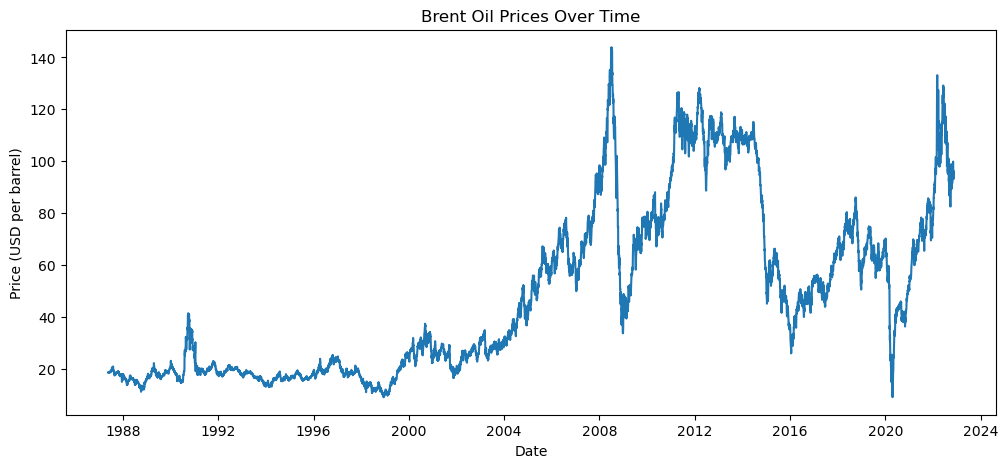

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.show()

Compute and analyze log returns

In [12]:
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
df.head()

,Date,Price,log_price,log_return
0,1987-05-20,18.63,2.924773,NaN
1,1987-05-21,18.45,2.915064,-0.009709
2,1987-05-22,18.55,2.920470,0.005405
3,1987-05-25,18.60,2.923162,0.002692
4,1987-05-26,18.63,2.924773,0.001612


Plot log returns (volatility clustering)

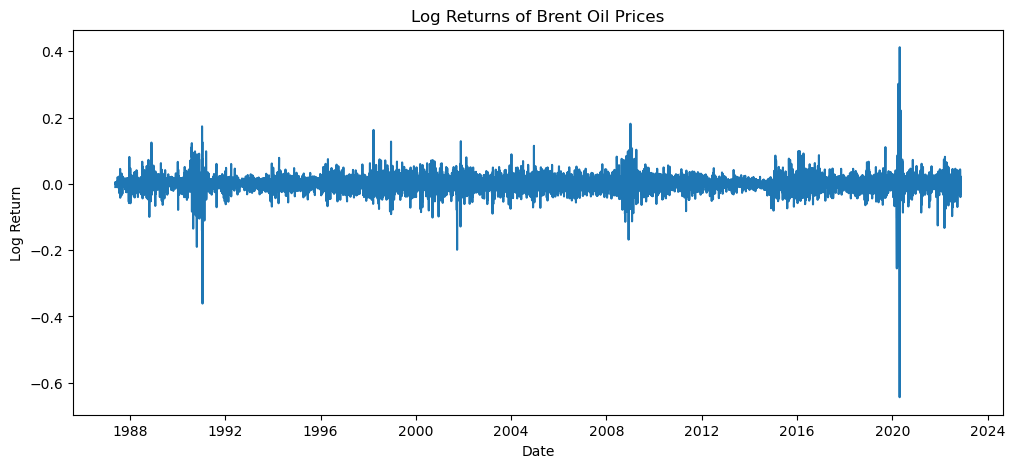

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

Prepare data for modeling

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        9011 non-null   datetime64[ns]
 1   Price       9011 non-null   float64       
 2   log_price   9011 non-null   float64       
 3   log_return  9010 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 281.7 KB


In [20]:
df_copy = df[df['Date'] >= '2018-01-01'].copy()

In [23]:

price_data = df_copy["Price"].values
n = len(price_data)

Define the Bayesian change point model

In [24]:
with pm.Model() as change_point_model:

    # Switch point
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Before and after means
    mu_1 = pm.Normal("mu_1", mu=price_data.mean(), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=price_data.mean(), sigma=10)

    # Shared standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Mean function using switch
    mu = pm.math.switch(np.arange(n) < tau, mu_1, mu_2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=price_data)

    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6841 seconds.


Convergence check
✔️ Look for:

r_hat ≈ 1.0

Reasonable effective sample size

In [25]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,954.802,3.188,949.000,960.000,0.077,0.056,1721.0,2039.0,1.0
mu_1,60.945,0.472,60.068,61.862,0.004,0.005,11098.0,5853.0,1.0
mu_2,97.869,0.856,96.268,99.500,0.009,0.010,8601.0,6087.0,1.0
sigma,14.377,0.290,13.815,14.910,0.003,0.003,11082.0,6256.0,1.0


Trace plots

array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'mu_1'}>,
        <Axes: title={'center': 'mu_1'}>],
       [<Axes: title={'center': 'mu_2'}>,
        <Axes: title={'center': 'mu_2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

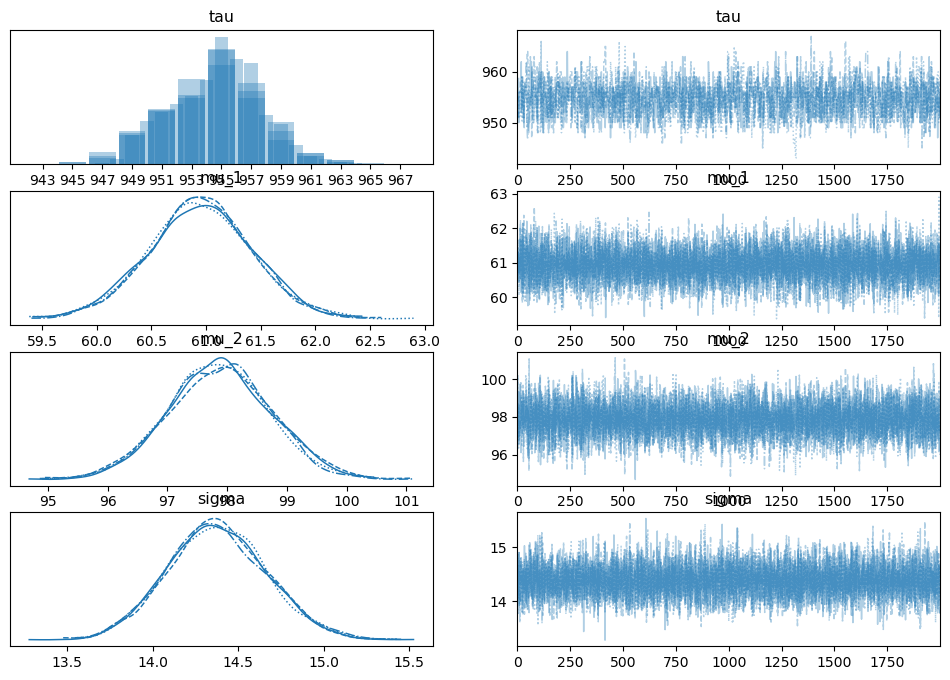

In [26]:
az.plot_trace(trace)

Compare before vs after prices

array([<Axes: title={'center': 'mu_1'}>, <Axes: title={'center': 'mu_2'}>],
      dtype=object)

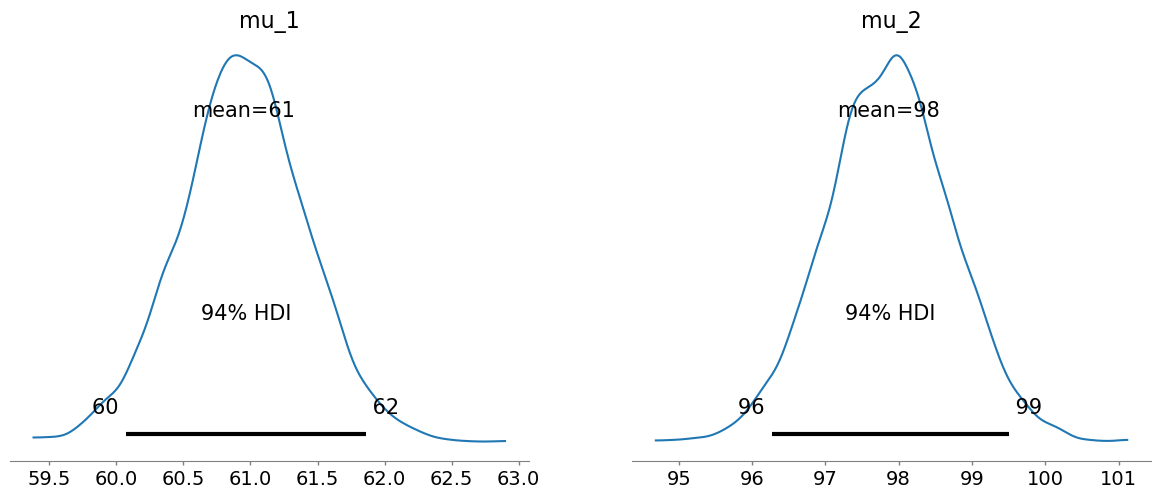

In [27]:
az.plot_posterior(trace, var_names=["mu_1", "mu_2"])

Filter price data (you already did this)

In [34]:
dates = df_copy["Date"].values

In [35]:

tau_samples = trace.posterior["tau"].values.flatten()

# Posterior mean (or median is also fine)
tau_hat = int(tau_samples.mean())

change_point_date = dates[tau_hat]

change_point_date


np.datetime64('2021-09-30T00:00:00.000000000')

Quantify before/after price levels

In [28]:
mu_1_samples = trace.posterior["mu_1"].values.flatten()
mu_2_samples = trace.posterior["mu_2"].values.flatten()

mu_1_mean = mu_1_samples.mean()
mu_2_mean = mu_2_samples.mean()

pct_change = (mu_2_mean - mu_1_mean) / mu_1_mean * 100

mu_1_mean, mu_2_mean, pct_change

(np.float64(60.94503361030453),
 np.float64(97.86901337938725),
 np.float64(60.58570745104923))

This gives you:

X = μ₁ (before)

Y = μ₂ (after)

Z% change

✔️ This directly satisfies Task 2(e).

Load and align event data

In [31]:
events = pd.read_csv("../data/raw/oil_market_events.csv")
events["Date"] = pd.to_datetime(events["Date"])

# Focus on relevant time window
events_recent = events[
    (events["Date"] >= df_copy["Date"].min()) &
    (events["Date"] <= df_copy["Date"].max())
]

events_recent

,Date,Event,Category,Description
9,2018-05-08,US Iran Sanctions,Economic Sanctions,Reduced Iranian oil exports
10,2020-03-11,COVID-19 Pandemic,Global Crisis,Collapse in global oil demand
11,2020-04-20,Oil Price Crash,Market Shock,Negative WTI prices reflect extreme market stress
12,2022-02-24,Russia–Ukraine War,Geopolitical Conflict,Sanctions and major supply disruptions


Match change point to nearest event (code-based)

Define a ±60 day window:

In [40]:
window_days = 60

events_recent["days_diff"] = (
    events_recent["Date"] - pd.to_datetime(change_point_date)
).abs().dt.days

likely_event = events_recent.sort_values("days_diff").iloc[0]

likely_event


C:\Users\hp\AppData\Local\Temp\ipykernel_27624\2344404381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_recent["days_diff"] = (


Date                              2022-02-24 00:00:00
Event                              Russia–Ukraine War
Category                        Geopolitical Conflict
Description    Sanctions and major supply disruptions
days_diff                                         147
Name: 12, dtype: object

Auto-generate the insight statement (VERY powerful)

In [37]:
statement = (
    f"Following the {likely_event['Event']} around "
    f"{likely_event['Date'].date()}, the model detects a change point "
    f"near {pd.to_datetime(change_point_date).date()}. "
    f"The average price shifted from approximately "
    f"${mu_1_mean:.2f} to ${mu_2_mean:.2f}, "
    f"representing a {pct_change:.2f}% change."
)

statement

'Following the Russia–Ukraine War around 2022-02-24, the model detects a change point near 2021-09-30. The average price shifted from approximately $60.95 to $97.87, representing a 60.59% change.'